In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modules.csvLoader import csvLoader

%load_ext autoreload
%autoreload 2

## Définition de fonctions utiles

In [2]:
def drop_extreme(df, colonne, low_qt, high_qt):
    limite_basse, limite_haute = df[colonne].quantile([low_qt, high_qt])
    return df.query("{low}<=`{colonne}`<={high}".format(low=limite_basse,high=limite_haute,colonne=colonne))

## Lecture des csv

In [3]:
maison_filtre = csvLoader.load('maison')

Successfully loaded  maison.csv


## Observation sur les types de mutation et leur influence sur la valeur de la maison

In [4]:
mutations = maison_filtre['Nature mutation'].drop_duplicates().tolist()
for mutation in mutations:
    df = maison_filtre[maison_filtre['Nature mutation']==mutation]
    print('nb ', mutation[:15], ' :\t', len(df), '\tsoit\t', round(len(df)/len(maison_filtre)*100, 2), ' % des maisons' )

del(mutation, mutations, df)

print()
print('Valeur moyenne par type de bien')
maison_valeur = maison_filtre[['Nature mutation', 'Valeur fonciere']]
print( maison_valeur.groupby(['Nature mutation']).mean().head() )

del(maison_valeur)

print()
print(len(maison_filtre))
maison_filtre = maison_filtre[maison_filtre['Nature mutation'] == 'Vente']
print(len(maison_filtre))

nb  Vente  :	 489535 	soit	 99.55  % des maisons
nb  Vente en l&#39;état  :	 253 	soit	 0.05  % des maisons
nb  Echange  :	 694 	soit	 0.14  % des maisons
nb  Adjudication  :	 1124 	soit	 0.23  % des maisons
nb  Vente terrain à  :	 132 	soit	 0.03  % des maisons
nb  Expropriation  :	 10 	soit	 0.0  % des maisons

Valeur moyenne par type de bien
                                    Valeur fonciere
Nature mutation                                    
Adjudication                           1.427672e+05
Echange                                1.791159e+05
Expropriation                          1.582530e+05
Vente                                  3.727974e+05
Vente en l&#39;état futur d&#39;achèvement     2.006223e+06

491748
489535


## Suppression des extremes de Nombre de pieces

In [5]:
if len(maison_filtre) < 465000:
    raise SystemExit("Ce traitement a déjà été effectué !")

print(len(maison_filtre))
maison_filtre = drop_extreme(maison_filtre, 'Nombre pieces principales', 0.1, 0.9)
print(len(maison_filtre))

nb_pieces = maison_filtre['Nombre pieces principales'].drop_duplicates().tolist()
nb_pieces.sort()
for piece in nb_pieces:
    df = maison_filtre[maison_filtre['Nombre pieces principales']==piece]
    print(int(piece), ' pièces :', len(df), '\tsoit\t', round(len(df)/len(maison_filtre)*100, 2), ' % des maisons' )

del(nb_pieces, df, piece)

489535
411491
3  pièces : 92487 	soit	 22.48  % des maisons
4  pièces : 154406 	soit	 37.52  % des maisons
5  pièces : 115475 	soit	 28.06  % des maisons
6  pièces : 49123 	soit	 11.94  % des maisons


## Suppression des extremes de 'Valeur fonciere'

In [6]:
if len(maison_filtre) < 400000:
    raise SystemExit("Ce traitement a déjà été effectué !")

print(len(maison_filtre))
maison_filtre = drop_extreme(maison_filtre, 'Valeur fonciere', 0.05, 0.95)
print(len(maison_filtre))

411491
372302


## Suppression des extremes de 'Surface terrain'

In [7]:
if len(maison_filtre) < 350000:
    raise SystemExit("Ce traitement a déjà été effectué !")

print(len(maison_filtre))
maison_filtre = drop_extreme(maison_filtre, 'Surface terrain', 0.05, 0.95)
print(len(maison_filtre))

372302
335083


## Filtre sur les colonnes inutiles et concatenation des colonnes 'Surface Carrez' et 'Surface reelle'

In [8]:
maison_filtre = maison_filtre[['Nature mutation', 'Valeur fonciere', 'Code postal', 'Voie', 'Commune', '1er lot', 'Surface Carrez du 1er lot', 'Nombre de lots', 'Type local', 'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']]

import math

def set_surface(row):
    if math.isnan(row['Surface Carrez du 1er lot']):
        return row['Surface reelle bati']
    return row['Surface Carrez du 1er lot']

maison_filtre['Surface'] = maison_filtre.apply(set_surface, axis=1)
maison_filtre = maison_filtre.drop(columns=['Surface Carrez du 1er lot', 'Surface reelle bati'])

## Suppression des extremes de Surface

In [9]:
if len(maison_filtre) < 310000:
    raise SystemExit("Ce traitement a déjà été effectué !")

print(len(maison_filtre))
maison_filtre = drop_extreme(maison_filtre, 'Surface', 0.05, 0.95)
print(len(maison_filtre))

335083
304663


# Analyses et Graphs

## Relation de la taille du terrain (Y) avec le prix (X)

taille du sample :  30466


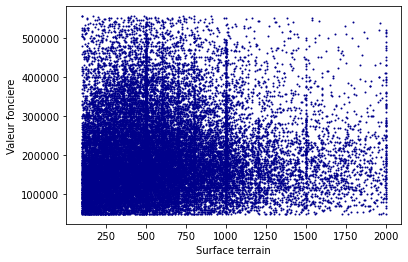

In [10]:
nb_sample = round(0.1*len(maison_filtre))
print('taille du sample : ', nb_sample)
plot = maison_filtre.sample(n=nb_sample).plot.scatter(x='Surface terrain', y='Valeur fonciere', c='DarkBlue', s=1)
del(nb_sample, plot)

## Recherche de correlation

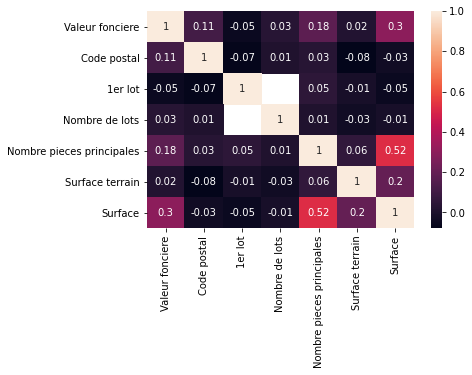

In [11]:
matrice = maison_filtre.corr().round(2)
sns.heatmap(data=matrice, annot=True)
del(matrice)

In [12]:
csvLoader.save(maison_filtre, 'maison_filtre', save_index=False)